In [116]:
#импортируем библиотеки

import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, precision_score

import warnings
warnings.filterwarnings("ignore")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [117]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')

Описания признаков

1. client_id - идентификатор клиента
2. education - уровень образования
3. sex - пол заемщика
4. age - возраст заемщика
5. car - флаг наличия автомобиля
6. car_type - флаг автомобиля иномарки
7. decline_app_cnt - количество отказанных прошлых заявок
8. good_work - флаг наличия “хорошей” работы
9. bki_request_cnt - количество запросов в БКИ
10. home_address - категоризатор домашнего адреса
11. work_address - категоризатор рабочего адреса
12. income - доход заемщика
13. foreign_passport - наличие загранпаспорта
14. sna - связь заемщика с клиентами банка
15. first_time - давность наличия информации о заемщике
16. score_bki - скоринговый балл по данным из БКИ
17. region_rating - рейтинг региона
18. app_date - дата подачи заявки
19. default - флаг дефолта по кредиту

In [118]:
#  для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['default'] = 0 # в тесте у нас нет значения

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [119]:
# осматриваем данные
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


In [120]:
# проверим датасет на наличие пропусков
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

<AxesSubplot:>

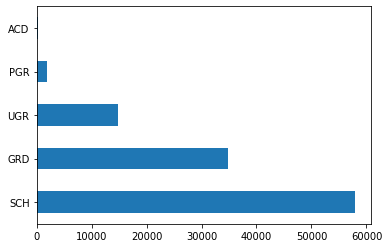

In [121]:
# осмотрим признак
data['education'].value_counts().plot.barh()

In [122]:
# заменяем пропуски с помощью вероятностного присвоения
mask = data["education"].isna()
# считаем статистику распределения значений
p = data["education"].value_counts() / len(data["education"].dropna())
# заполняем пропуски с вероятностью `p`
data.loc[mask, "education"] = \
    np.random.choice(p.index.to_list(), 
                     size=mask.sum(), 
                     p=p.to_list())

In [123]:
# проверим результат 
data.isnull().sum().sum()

0

In [124]:
# преобразуем признак 'app_date' в приемлимый формат и извлечём данные, с которыми можно работать:
data['app_date'] = pd.to_datetime(data['app_date'])
data['app_day'] = data.app_date.dt.day     # извлекли в 
data['app_month'] = data.app_date.dt.month
data["app_weekday"] = data["app_date"].dt.weekday
# удалим теперь уже ненужный столбец
data.drop(["app_date"], axis=1, inplace=True)

In [125]:
# разделим признаки по категориям:

# числовые признаки
num_cols = data[["age", "decline_app_cnt", "score_bki",
            "bki_request_cnt", "income"]]

# бинарные признаки
bin_cols = data[["sex", "car", "car_type", "good_work", "foreign_passport"]]

# категориальные признаки
cat_cols = data[["education", "region_rating", "home_address", "work_address", "sna"
                 ,"app_day", "app_month", "app_weekday", "first_time"]]

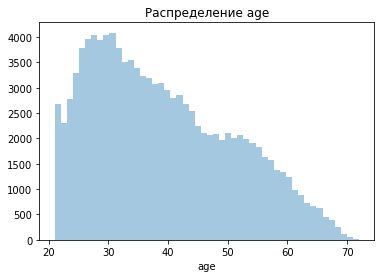

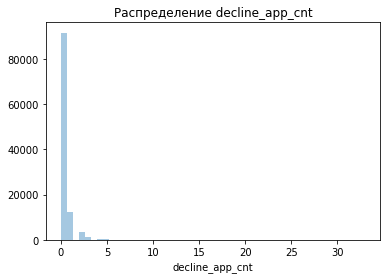

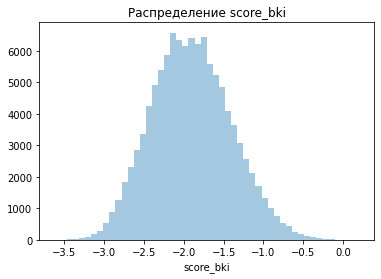

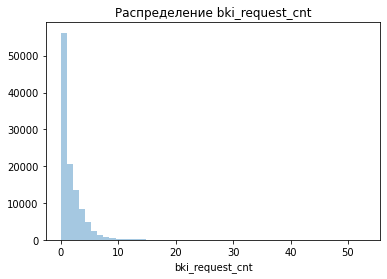

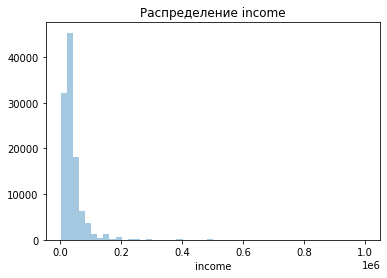

In [126]:
# осмотрим числовые признаки
for col in num_cols:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(data[col], kde=False)

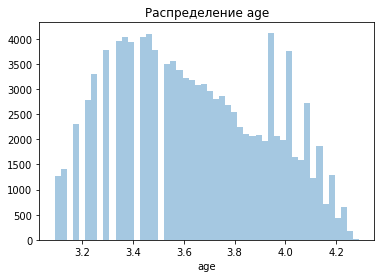

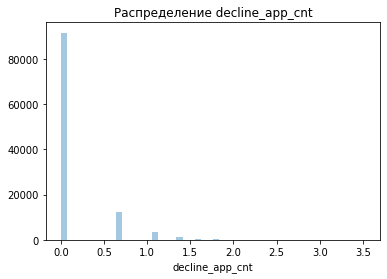

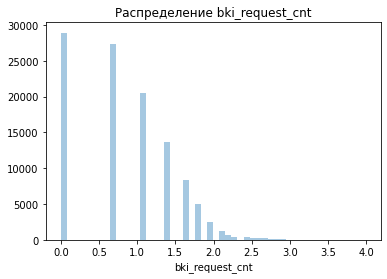

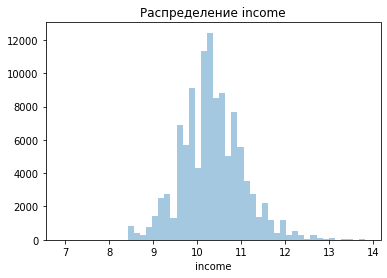

In [127]:
# для более нормального распределения, логарифмируем некоторые признаки
num_cols[["age", "decline_app_cnt", "bki_request_cnt", "income"]] = np.log(num_cols[["age",
                            "decline_app_cnt", "bki_request_cnt", "income"]] + 1)
# и сразу их осмотрим
for col in num_cols[["age", "decline_app_cnt", "bki_request_cnt", "income"]]:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(num_cols[col], kde=False)

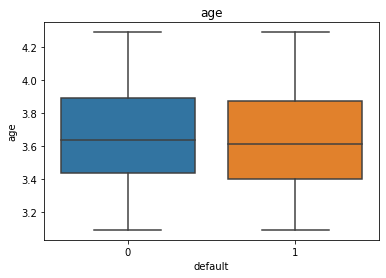

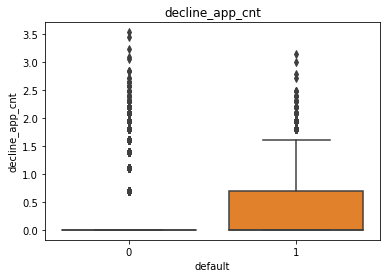

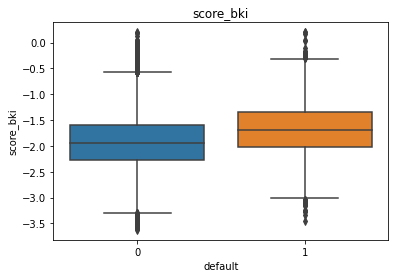

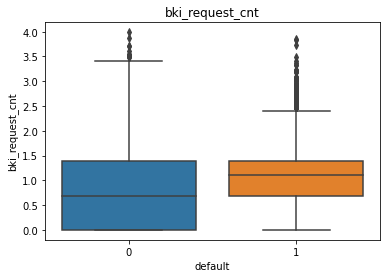

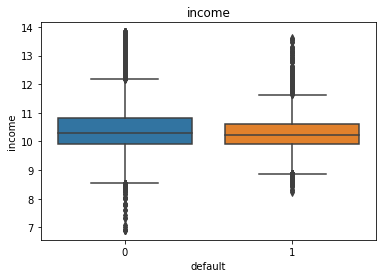

In [128]:
# взглянем на боксплоты числовых переменных, относительно целевой
for i in num_cols:
    plt.figure()
    sns.boxplot(x=data['default'], y = num_cols[i])
    plt.title(i)
    plt.show()

1. возраст дефолтных клиентов меньше
2. дефолтные клиенты часто уже имели отказные заявки 
3. скоринговый балл у дефолтных выше
4. у дефолтных клиентов больше запросов на кредит
5. доход у дефолтных, в среднем, ниже


In [129]:
def outliers(row):
    """функция для замены выбросов на среднее"""
    q_1 = np.quantile(row, 0.25) 
    q_3 = np.quantile(row, 0.75) 
    IQR = q_3 - q_1
    return np.where((row < (q_1 - IQR * 1.5)) | (row > (q_3 + IQR * 1.5)), row.mean(), row)

In [130]:
# избавимся от выбросов 
for col in ['income']:
    num_cols[col] =  outliers(num_cols[col])

In [131]:
# создадим признак "количество согласованных заявок"
num_cols['acepted_request'] = num_cols['bki_request_cnt'] - num_cols['decline_app_cnt']

<AxesSubplot:>

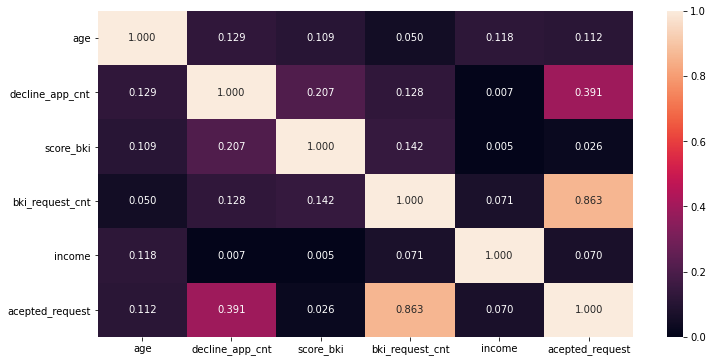

In [132]:
# посмотрим на корреляцию признаков между собой
plt.figure(figsize=(12, 6))
sns.heatmap(num_cols.corr().abs(), vmin=0, vmax=1,
            annot=True, fmt=".3f")

На графике можно увидеть небольшую корреляцию между app_month и app_day, decline_app_cnt и score_bki


<AxesSubplot:>

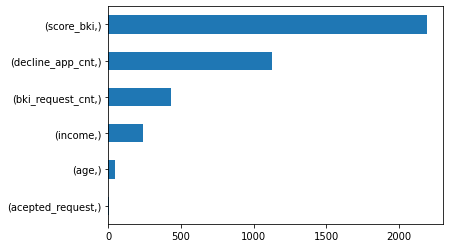

In [133]:
#определяем значимость наших переменных
imp_num = pd.Series(f_classif(num_cols, data['default'])[0], index=[num_cols.columns])
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [134]:
# заменяем бинарные категориальные признаки

label_encoder = LabelEncoder()
for column in bin_cols:
    bin_cols[column] = label_encoder.fit_transform(data[column])

<AxesSubplot:>

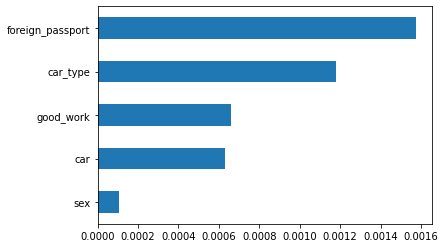

In [135]:
# произведём оценку значимости категориальных бинарных переменных
imp_cat = pd.Series(mutual_info_classif(bin_cols, data['default'],
                                     discrete_features =True), index = bin_cols.columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [136]:
#преобразуем education
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(data['education']))
print(dict(enumerate(label_encoder.classes_))) # чтобы не забыть что куда преобразилось
cat_cols['education'] = mapped_education

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


In [137]:
# воспользуемся dummy-кодированием для категориальных переменных
X_cat = OneHotEncoder(sparse=False).fit_transform(cat_cols.values)

X_cat = pd.DataFrame(X_cat)

In [138]:
# добавим новые признаки, через комбинацию чиловых признаков
poly = PolynomialFeatures(2, include_bias=False)
poly_data = poly.fit_transform(num_cols) 
poly_cols = poly.get_feature_names(input_features=None)

# создадим из них новый df
poly_df = pd.DataFrame(poly_data, columns=poly_cols)

# сделаем итоговый df для числовых
total_num = num_cols.join(poly_df,  how='left')

In [142]:
#стандартизация числовых переменных
total_num = pd.DataFrame(StandardScaler().fit_transform(total_num), columns = total_num.columns)

In [143]:
# объединим обработку в один датасет
data_for_fit = total_num.join(X_cat)
data_for_fit = data_for_fit.join(bin_cols)
data_for_fit = data_for_fit.join(data[['sample', 'default']])

In [144]:
# вновь разделимь на тренеровочный и тестовый
train = data_for_fit.query('sample == 1').drop(['sample'], axis=1)
test = data_for_fit.query('sample == 0').drop(['sample'], axis=1)

In [145]:
# подготовим данные к сплину
Y = train['default'].values
train.drop(["default"], axis=1, inplace=True)
test.drop(["default"], axis=1, inplace=True)
X = train.values
test = test.values

In [146]:
# сплитим данные
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1, shuffle=True)

In [ ]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
#C = np.logspace(0, 5, 10)
C = np.arange(0, 3, 0.1)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# Отобразим лучшие гиперпараметры
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшая регуляризация - l2, с силой регуляризации C = 0.1
станартные параметны логистической регрессии останутся без изменений

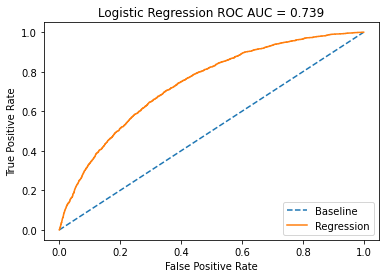

In [147]:
# обозначаем модель
model = LogisticRegression(penalty='l2', C=0.1, max_iter=1000)

# обучаем модель
model.fit(X_train, y_train)

# делаем предсказание
probs = model.predict_proba(X_test)
probs = probs[:,1]

#рисуем ROC кривую
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [148]:
# коэффициенты нашей модели
coef = np.exp(model.coef_[0]) 

# представим их в виде датафрейма
pd.DataFrame(coef, train.columns)

,0
age,1.214285
decline_app_cnt,1.168815
score_bki,1.258997
bki_request_cnt,0.973317
income,0.989420
...,...
sex,1.294349
car,0.987318
car_type,0.799688
good_work,0.804587
